 
# Predict TripAdvisor Rating
### Goal: 
 
Predict a restaurant's TripAdvisor rating and get a Mean Absolute Error (MAE) < 0.22 
 
### Tasks:
 
- Make preprocessing of various data
- Handle missing data (NaN)
- Encode and get new signs
(Feature Engineering)

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings; warnings.simplefilter('ignore') #ignore warnings
 
# We load a special convenient tool for splitting a dataset:
from sklearn.model_selection import train_test_split
 
# fix the version of packages and seed so that experiments are reproducible: 
RANDOM_SEED = 42
!pip freeze > requirements.txt
 
# function for finding the city average
def fill_na(column): # get column
  city_list = data.City.unique() # finding unique values in cities
  for city in city_list:
    mean_price = data[column][data['City']==city].mean() # find mean for column
    data[column][data['City']==city] = data[column][data['City']==city].fillna(mean_price) # filling NaN values
  return data
 
# function for create conbine feature from dummy values
def dummy(column):
  column = column.apply(lambda x: x-x.mean()) # subtract mean
  column = column.apply(lambda x: x/np.linalg.norm(x)) # normalization
  column = [column.iloc[x].sum() for x in range(len(column))] # summing values in row
  column = column / np.linalg.norm(column) # normalization
  return column

# function for leaving top values
def other(column):
  values_count = data[column].value_counts() # unique values and count
  top = np.percentile(values_count, 90) # top 10
  values_df = pd.DataFrame(values_count).reset_index() # create dataframe and reset index
  index_top=values_df[column][values_df[column] == top].index[0] # find index of top values
  return list(values_df[index_top:]['index']) # return list of non top values

## DATA

In [2]:
df_train = pd.read_csv('main_task.csv') #main_task.csv')
df_test = pd.read_csv('kaggle_task.csv') #kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv') #sample_submission.csv')
 
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [3]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [4]:
sample_submission.info()
sample_submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [5]:
# for correct processing of features, combine the train and test into one dataset
df_train['sample'] = 1 # mark where we have train
df_test['sample'] = 0 # mark where we have the test
df_test['Rating'] = 0 # in the test we do not have the Rating value, we must predict it, so for now we just fill it with zeros
 
data = df_test.append(df_train, sort=False).reset_index(drop=True) # unite
 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


More on the signs:

- City: City
- Cuisine Style: Cuisine
- Ranking: Rank of the restaurant relative to other restaurants in the city
- Price Range: Restaurant prices in 3 categories
- Number of Reviews: Number of Reviews
- Reviews: 2 most recent reviews and the dates of these reviews
- URL_TA: Restaurant page on 'www.tripadvisor.com'
- ID_TA: ID of the restaurant on TripAdvisor
- Rating: Rating of the restaurant

In [6]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
21995,id_1660,Lisbon,"['European', 'Contemporary', 'Healthy', 'Portu...",1661.0,$$ - $$$,3.0,"[[], []]",/Restaurant_Review-g189158-d13163694-Reviews-S...,d13163694,1,5.0
29394,id_1101,Warsaw,"['Italian', 'French', 'Chinese', 'Polish', 'Eu...",1102.0,$,NaN,"[[], []]",/Restaurant_Review-g274856-d12871470-Reviews-M...,d12871470,1,5.0
8319,id_8319,Rome,"['Italian', 'Mediterranean', 'Wine Bar', 'Vege...",305.0,$$ - $$$,2760.0,"[['Delicious and good value for money', 'Fabul...",/Restaurant_Review-g187791-d786482-Reviews-Vin...,d786482,0,0.0
18594,id_13811,London,"['Japanese', 'Asian', 'Sushi']",13821.0,$$ - $$$,70.0,"[['Authentic Izakaya', 'Brilliant'], ['11/18/2...",/Restaurant_Review-g186338-d1044792-Reviews-Yo...,d1044792,1,3.5
43350,id_55,Hamburg,"['German', 'Seafood', 'European', 'Soups']",56.0,$$ - $$$,373.0,"[['Fantastic meal- both fisch and wein', 'Good...",/Restaurant_Review-g187331-d954481-Reviews-Fis...,d954481,1,4.5


## Cleaning and Prepping Data

### 1. 'City'

In [7]:
data['city_norm'] = dummy(pd.get_dummies(data.City)) # create dummy feature

# create feature contain restaurants count in city
count_res = data.groupby(["City"])["Restaurant_id"].count() # restaurants count
dict_res = dict(zip(count_res.keys(),count_res.values)) # create dictionary
data['City_Rank'] = data['City'].replace(to_replace=dict_res) # replacing city on restaurants count
data['City_Rank'] = data['Ranking']/data['City_Rank'] # devision on City_Rank
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,City_Rank
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,2.122299
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.223158
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,1.087248
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,0.232031
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.097368


<AxesSubplot:>

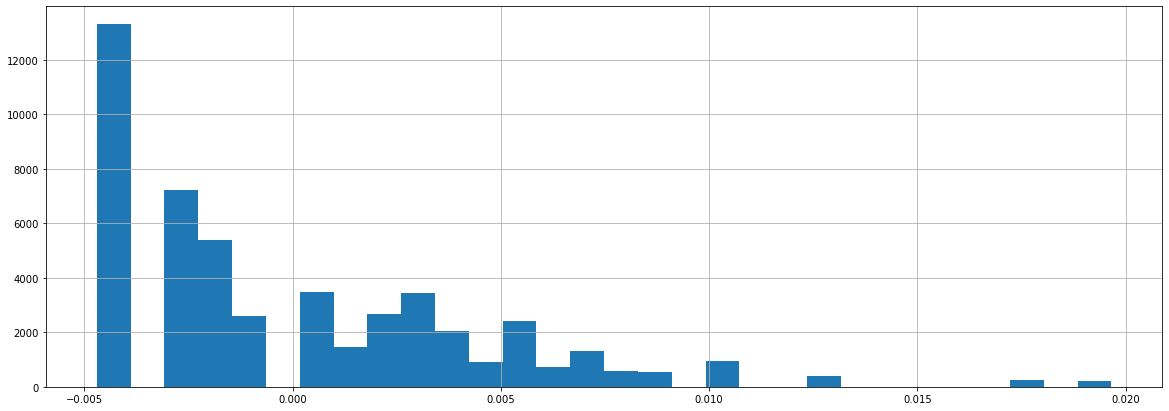

In [9]:
plt.rcParams['figure.figsize'] = (20,7)
data['city_norm'].hist(bins=30)

<AxesSubplot:>

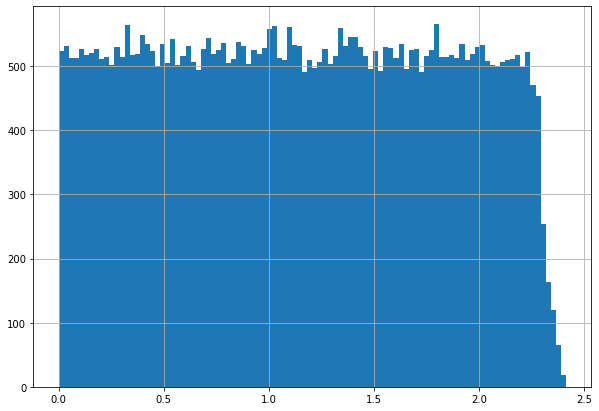

In [10]:
plt.rcParams['figure.figsize'] = (10,7)
data['City_Rank'].hist(bins=100)

### 2. 'Cuisine Style'

In [8]:
# create four new features: a feature based on all unique cuisines, 
#  their number in the restaurant, nan feature and cuisines count devision on City_Rank
 
cuisines = [] # rows dummy
cuis_dict = {} # for saving index cuisine in list
cuis_count = [] # for saving cuisines count
 
# create dummy values for cuisines
for index in data.index:
  string = data['Cuisine Style'][index] # copping value of cuisines
  if str(string) != 'nan':
    i=0 # index of string
    j=0 # count of cuisines
    
    # the new row in list filled with zeros depending on the number of keys in the dictionary:
    cuisines.append([0 for x in range(len(cuis_dict))]) 
    
    while i<len(string)-1:
      str_cuis = string.find("'",string.find("'",i)+1) # the index of the next apostrophe in the string 
      cuisine = string[string.find("'",i)+1:str_cuis] # cut cuisine from string
      
      if cuisine not in cuis_dict.keys(): # new cuisine
        cuis_dict[cuisine] = len(cuis_dict) # save index cuisine
        cuisines[index].append(1) # save '1' in end of list
      else:
        cuisines[index][cuis_dict[cuisine]] = 1
      
      i = str_cuis + 1 # next symbol
      j += 1 # plus cuisine
    cuis_count.append(j) # save count
  else: 
    cuis_count.append(None) 
    cuisines.append([None for x in range(len(cuis_dict))])  
 
# create new feature
cuisines = pd.DataFrame(cuisines, columns = list(cuis_dict.keys())) 
cuisines = cuisines.dropna(how='all') # delete empty rows
cuisines = cuisines.fillna(0) # fill NaN zeros
cuis_undex = cuisines.index # save index
cuisines = dummy(cuisines) # create dummy
cuisines = pd.DataFrame({'cuis_norm':cuisines}, index=cuis_undex) # create dataframe with values and empty rows
 
# fill empty row in cuisines
data = pd.concat([data,cuisines], axis=1) # concatanate tables
data = fill_na('cuis_norm') # fill empty
 
# create new column with count in data and fill empty values
data['cuis_count'] = cuis_count
data = fill_na('cuis_count')
 
# create feature from nan of cuisine
data['Cuisine Style is NAN'] = pd.isna(data['Cuisine Style']).astype('uint8')
 
data['Cuis_Rank'] = data['Ranking']/data['cuis_count'] # cuisines count devision on City_Rank
 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,City_Rank,cuis_norm,cuis_count,Cuisine Style is NAN,Cuis_Rank
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,2.122299,-0.003014,2.0,0,6481.500000
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.223158,0.002108,5.0,0,21.200000
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,1.087248,-0.005033,1.0,0,810.000000
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,0.232031,-0.000846,5.0,0,333.800000
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.097368,0.001082,6.0,0,6.166667


<AxesSubplot:>

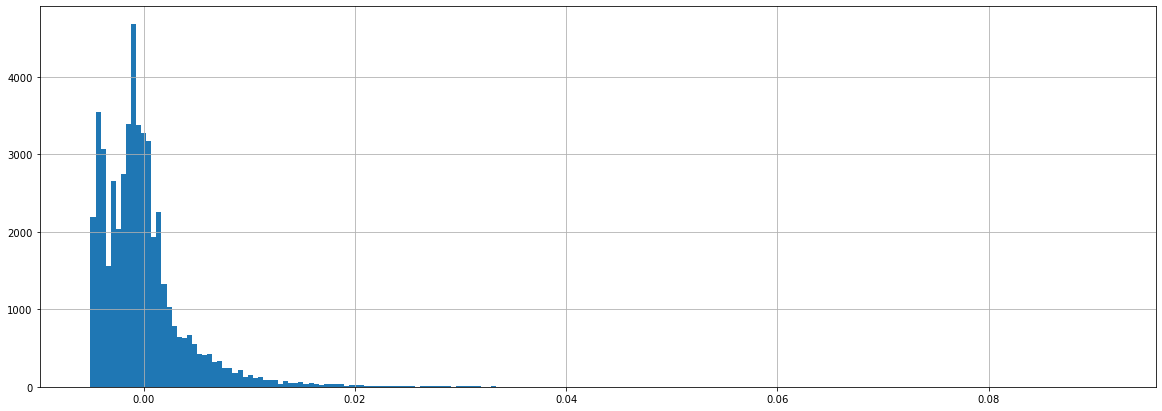

In [12]:
plt.rcParams['figure.figsize'] = (20,7)
data['cuis_norm'].hist(bins=200)

<AxesSubplot:>

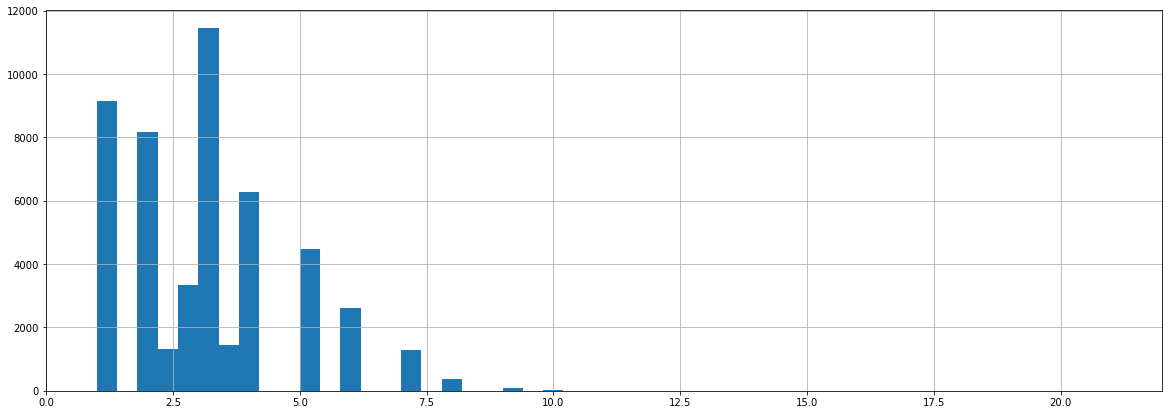

In [13]:
plt.rcParams['figure.figsize'] = (20,7)
data['cuis_count'].hist(bins=50)

<AxesSubplot:>

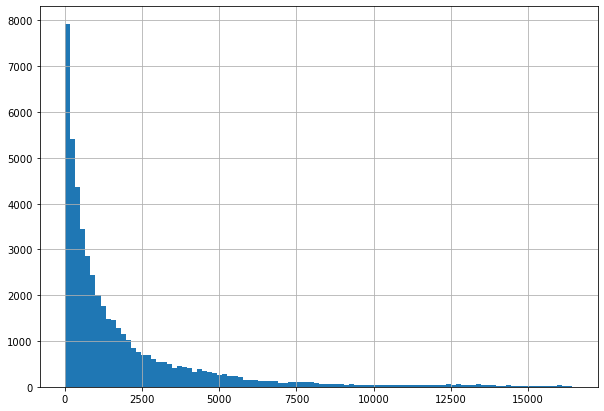

In [14]:
plt.rcParams['figure.figsize'] = (10,7)
data['Cuis_Rank'].hist(bins=100)

<AxesSubplot:>

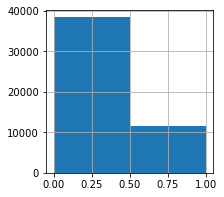

In [15]:
plt.rcParams['figure.figsize'] = (3,3)
data['Cuisine Style is NAN'].hist(bins=2)

### 3. 'Price Range'

In [9]:
# create dictionary and fill empty values:
 
price_dict = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)
 
# create feature of nan
data['Price Range is NAN'] = pd.isna(data['Price Range']).astype('uint8')
 
data = fill_na('Price Range') # filling empty
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,City_Rank,cuis_norm,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,2.122299,-0.003014,2.0,0,6481.500000,0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.223158,0.002108,5.0,0,21.200000,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,1.087248,-0.005033,1.0,0,810.000000,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,0.232031,-0.000846,5.0,0,333.800000,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.097368,0.001082,6.0,0,6.166667,0


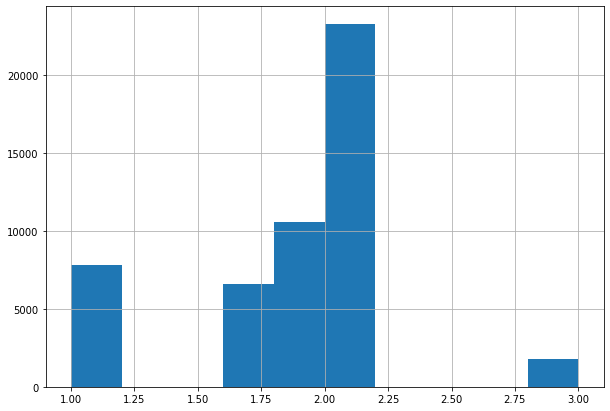

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
data['Price Range'].hist(bins=10)

<AxesSubplot:>

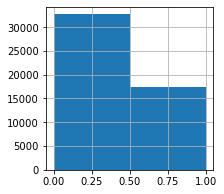

In [17]:
plt.rcParams['figure.figsize'] = (3,3)
data['Price Range is NAN'].hist(bins=2)

### 4. 'Number of Reviews'

In [10]:
# create nan feature and filling empties
 
data['Number of Reviews is NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')
data = fill_na('Number of Reviews') 

# create feature devision Ranking on Number of Reviews
data['Reviews_number_Rank'] = data['Ranking']/data['Number of Reviews']
 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,city_norm,City_Rank,cuis_norm,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN,Number of Reviews is NAN,Reviews_number_Rank
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,-0.004292,2.122299,-0.003014,2.0,0,6481.500000,0,0,3240.750000
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0.010202,0.223158,0.002108,5.0,0,21.200000,0,0,1.092784
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0.006097,1.087248,-0.005033,1.0,0,810.000000,0,0,28.928571
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,-0.004700,0.232031,-0.000846,5.0,0,333.800000,0,0,8.262376
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0.012611,0.097368,0.001082,6.0,0,6.166667,0,0,0.228395


<AxesSubplot:>

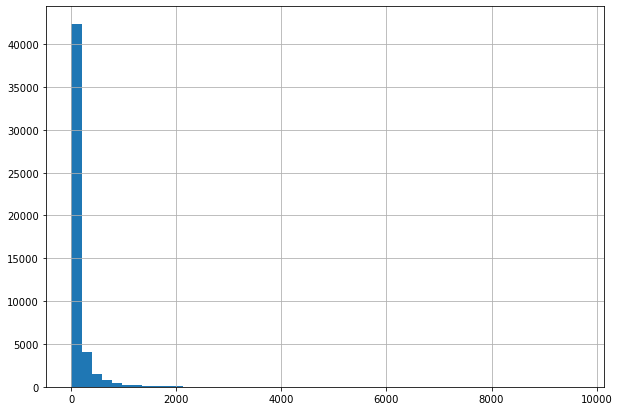

In [19]:
plt.rcParams['figure.figsize'] = (10,7)
data['Number of Reviews'].hist(bins=50)

<AxesSubplot:>

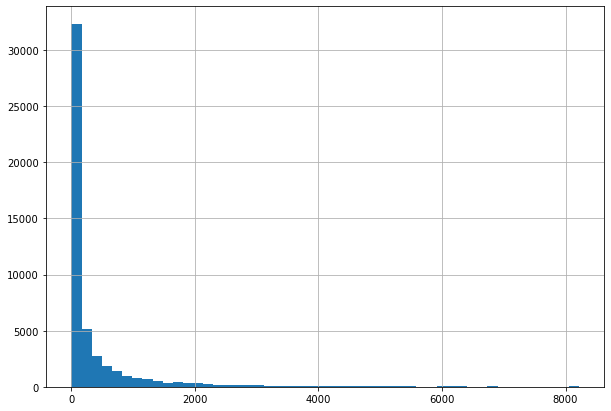

In [20]:
plt.rcParams['figure.figsize'] = (10,7)
data['Reviews_number_Rank'].hist(bins=50)

<AxesSubplot:>

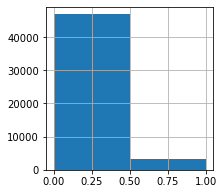

In [21]:
plt.rcParams['figure.figsize'] = (3,3)
data['Number of Reviews is NAN'].hist(bins=2)

### 5. 'Reviews'

In [11]:
# created new features: days count between reviews, length reviews, nan feature
 
pattern_time = re.compile('\d\d\/\d\d\/\d+') # patern for time
pattern_text = re.compile('[A-Za-z ]+') # pattern for text
time1 = []
time2 = [] 
len_text = [] 
 
for i in data.index:
  if str(data.Reviews[i]) == 'nan':
    data.Reviews[i] = '[[], []]'
  
  t_values = pd.to_datetime(pattern_time.findall(data.Reviews[i])) # find time string and transform it in time
    
  # save string lenth:
  if len(data.Reviews[i]) != 8:
    len_text.append(len(str(pattern_text.findall(data.Reviews[i]))))
  else: # if string lenth is eight than it empty
    len_text.append(None) 
  
  # save time:
  if len(t_values) == 0:
    time1.append(None)
    time2.append(None) 
  elif len(t_values) == 1:
    time1.append(t_values[0])
    time2.append(None) 
  else:
    time1.append(t_values[0])
    time2.append(t_values[1]) 
 
time = pd.DataFrame({'time1':time1, 'time2':time2})  
data['time_change'] = abs(time.time1-time.time2) # calculate difference
 
# transform in integer type and filling empty for time:
data['time_change'] = data['time_change'].apply(lambda x: int(x.days) if str(x.days) != 'nan' else None) 
data = fill_na('time_change')
 
# saving length and filling empty for reviews:
data['len_reviews'] = len_text
data['Reviews is NAN'] = pd.isna(data['len_reviews']).astype('uint8') # nan feature
data = fill_na('len_reviews')
 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,cuis_norm,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN,Number of Reviews is NAN,Reviews_number_Rank,time_change,len_reviews,Reviews is NAN
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,-0.003014,2.0,0,6481.500000,0,0,3240.750000,172.991084,66.201194,1
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,0.002108,5.0,0,21.200000,0,0,1.092784,37.000000,64.000000,0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,-0.005033,1.0,0,810.000000,0,0,28.928571,22.000000,53.000000,0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,-0.000846,5.0,0,333.800000,0,0,8.262376,14.000000,60.000000,0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,0.001082,6.0,0,6.166667,0,0,0.228395,15.000000,72.000000,0


<AxesSubplot:>

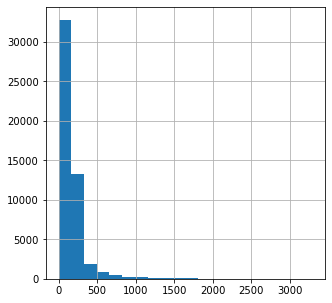

In [23]:
plt.rcParams['figure.figsize'] = (5,5)
data['time_change'].hist(bins=20)

<AxesSubplot:>

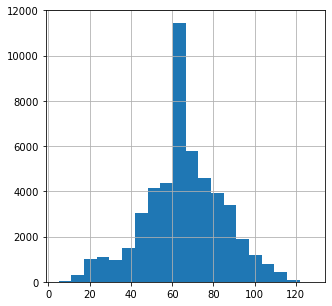

In [25]:
plt.rcParams['figure.figsize'] = (5,5)
data['len_reviews'].hist(bins=20)

<AxesSubplot:>

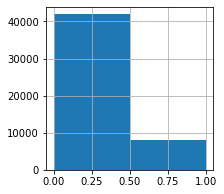

In [24]:
plt.rcParams['figure.figsize'] = (3,3)
data['Reviews is NAN'].hist(bins=2)

In [12]:
# create feature based on dummy from reviews
 
pattern_text = re.compile('[A-Za-z]+') # pattern for words
reviews = [] # rows dummy
rev_dict = {} # for saving index review in list
rev_list = [] # for saving found words
reviews_big = pd.DataFrame() #{'rev_norm':[]}) 
 
for i in range(5): # for economy operate memory devision data on 5
  reviews = []
  # create dummy values for reviews
  for index in range(10000):
    string = data['Reviews'][index+10000*i] # copping value of reviews
    if len(string) != 8:
    
      # the new row in list filled with zeros depending on the number of keys in the dictionary:
      reviews.append([0 for x in range(len(rev_dict))]) 
    
      rev_list = pattern_text.findall(data.Reviews[index+10000*i])
      for rev in rev_list:
      
        if rev not in rev_dict.keys(): # new review
          rev_dict[rev] = len(rev_dict) # save index cuisine
          reviews[index].append(1) # save '1' in end of list
        else:
          reviews[index][rev_dict[rev]] = 1
      
    else:  
      reviews.append([None for x in range(len(rev_dict))])  
 
  # create new feature
  reviews = pd.DataFrame(reviews, columns = list(rev_dict.keys())) 
  reviews = reviews.dropna(how='all') # delete empty rows
  reviews = reviews.fillna(0) # fill NaN zeros
  rev_index = reviews.index # save index
  reviews = dummy(reviews) # create dummy
  reviews = pd.DataFrame({'rev_norm':reviews}, index=rev_index+10000*i) # create dataframe with values and empty rows
  reviews_big = reviews_big.append(reviews, sort=False) # collect data
 
# fill empty row in reviews
data = pd.concat([data,reviews_big], axis=1) # concatanate tables
data = fill_na('rev_norm') # fill empty
 
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN,Number of Reviews is NAN,Reviews_number_Rank,time_change,len_reviews,Reviews is NAN,rev_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,2.0,0,6481.500000,0,0,3240.750000,172.991084,66.201194,1,0.000211
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,5.0,0,21.200000,0,0,1.092784,37.000000,64.000000,0,0.001675
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1.0,0,810.000000,0,0,28.928571,22.000000,53.000000,0,0.014525
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,5.0,0,333.800000,0,0,8.262376,14.000000,60.000000,0,-0.004957
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,6.0,0,6.166667,0,0,0.228395,15.000000,72.000000,0,0.000067


<AxesSubplot:>

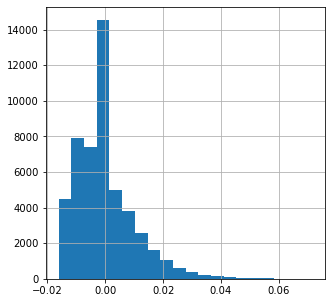

In [13]:
plt.rcParams['figure.figsize'] = (5,5)
data['rev_norm'].hist(bins=20)

## EDA

Exploratory Data Analysis - At this stage, we build graphs, look for patterns, anomalies, outliers or relationships between features. In general, the purpose of this stage is to understand what these data can give us and how the signs can be interrelated. Understanding the original features will allow us to generate new, stronger ones and, thereby, make our model better.

### Feature distribution

<AxesSubplot:>

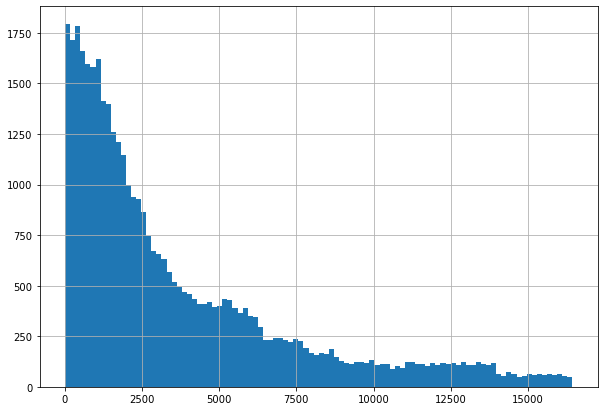

In [14]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

Many restaurants that do not even reach 2500 places in their city

<AxesSubplot:>

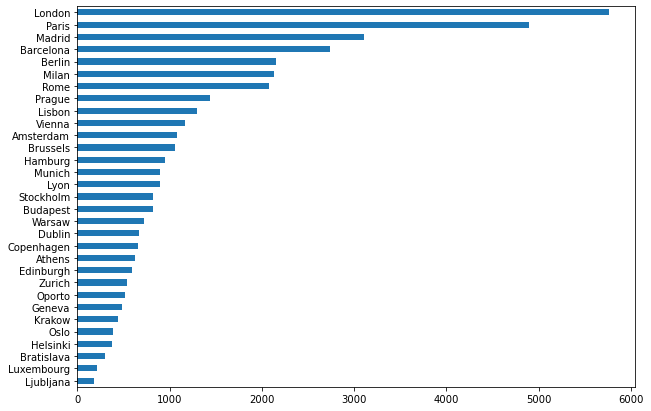

In [15]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

Most restaurants in london

Big city distribution:

<AxesSubplot:>

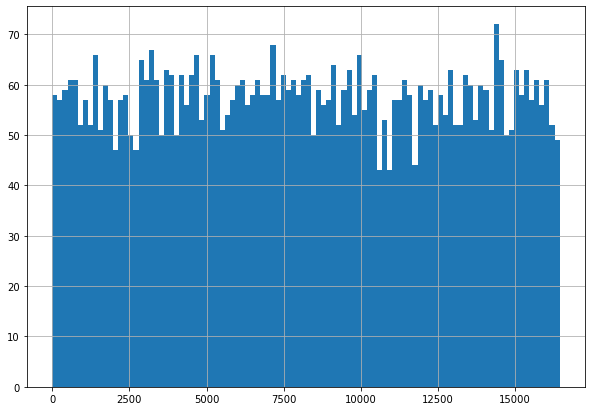

In [16]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

Look at the top 10 cities:

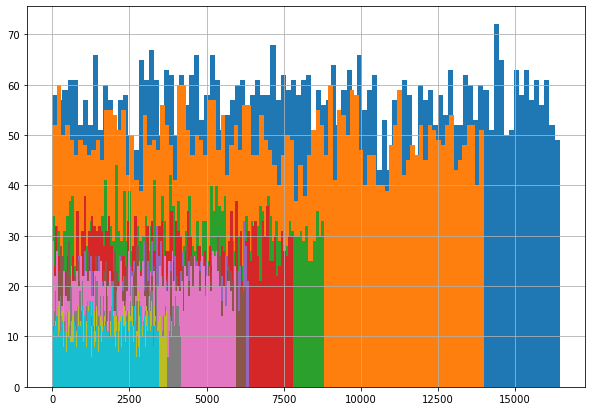

In [18]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Target variable distribution

<AxesSubplot:>

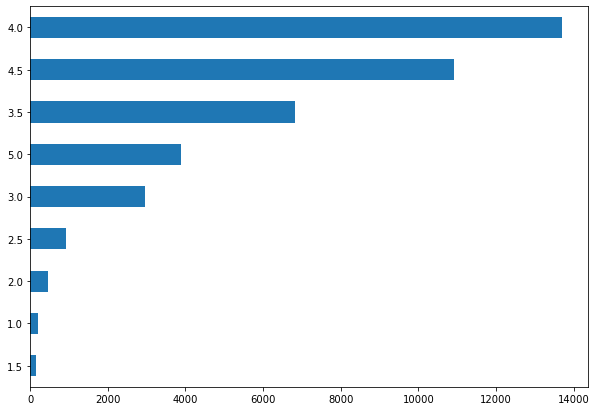

In [19]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Distribution of the target variable relative to the characteristic

<AxesSubplot:>

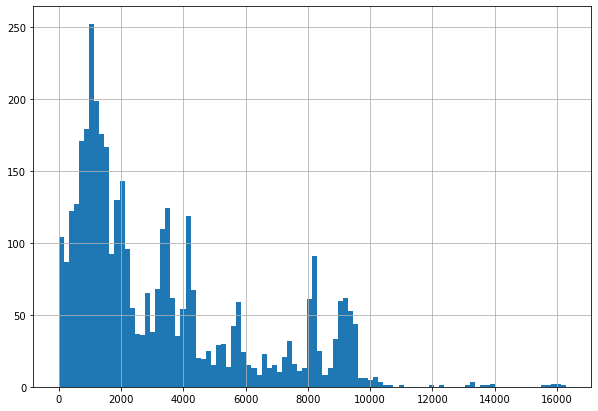

In [20]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

<AxesSubplot:>

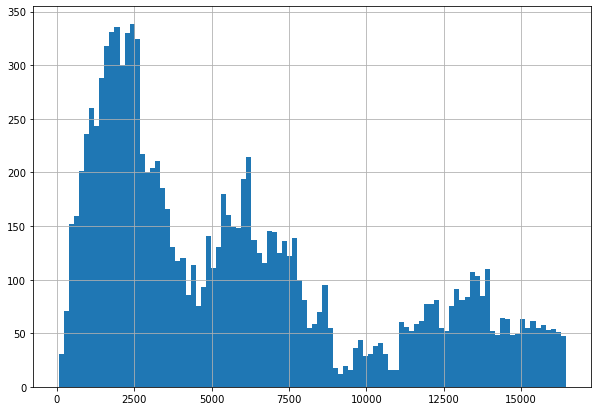

In [22]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Distributions are similar

### Feature correlation

<AxesSubplot:>

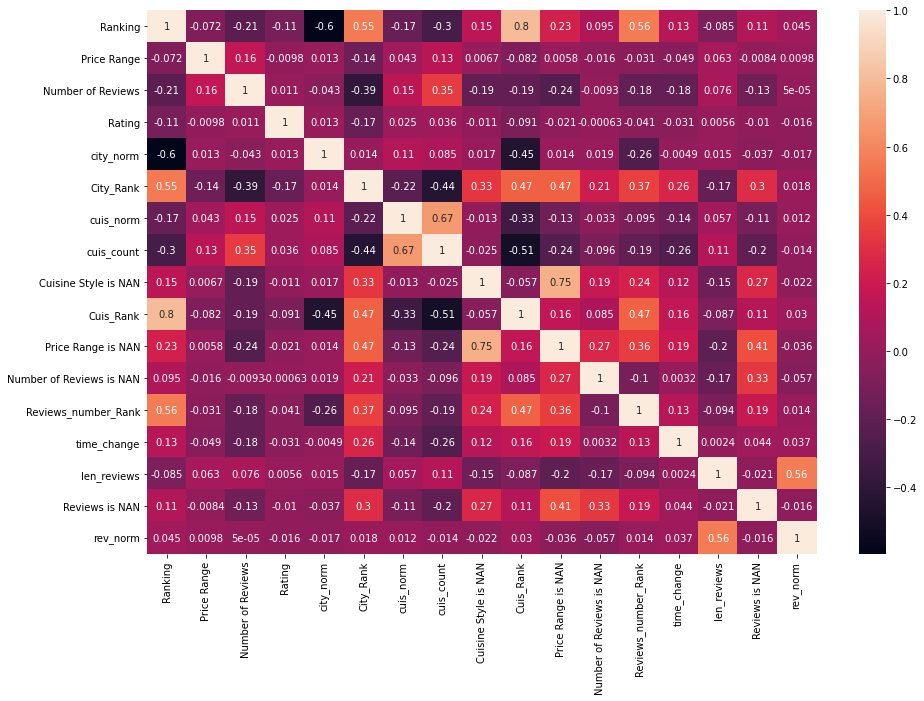

In [23]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),annot=True)

## Data Preprocessing

For convenience and reproducibility of the code, we will wrap all the processing in one big function

In [24]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Restaurant_id             50000 non-null  object 
 1   City                      50000 non-null  object 
 2   Cuisine Style             38410 non-null  object 
 3   Ranking                   50000 non-null  float64
 4   Price Range               50000 non-null  float64
 5   Number of Reviews         50000 non-null  float64
 6   Reviews                   50000 non-null  object 
 7   URL_TA                    50000 non-null  object 
 8   ID_TA                     50000 non-null  object 
 9   sample                    50000 non-null  int64  
 10  Rating                    50000 non-null  float64
 11  city_norm                 50000 non-null  float64
 12  City_Rank                 50000 non-null  float64
 13  cuis_norm                 50000 non-null  float64
 14  cuis_c

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN,Number of Reviews is NAN,Reviews_number_Rank,time_change,len_reviews,Reviews is NAN,rev_norm
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,...,2.0,0,6481.500000,0,0,3240.750000,172.991084,66.201194,1,0.000211
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,...,5.0,0,21.200000,0,0,1.092784,37.000000,64.000000,0,0.001675
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,...,1.0,0,810.000000,0,0,28.928571,22.000000,53.000000,0,0.014525
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,...,5.0,0,333.800000,0,0,8.262376,14.000000,60.000000,0,-0.004957
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,...,6.0,0,6.166667,0,0,0.228395,15.000000,72.000000,0,0.000067


In [25]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# Now let's select the test part
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
 
y = train_data.Rating.values            # our target
X = train_data.drop(['Rating'], axis=1)

Before sending our data for training, we will divide the data into another test and train for validation. This will help us test how well our model is performing before submitting the submissiona to kaggle.

In [26]:
# Let's use the special function train_test_split to split test data
# allocate 20% of the data for validation (parameter test_size)
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = RANDOM_SEED)
# check
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 17), (40000, 17), (40000, 16), (32000, 16), (8000, 16))

## Model

Сам ML

In [27]:
# Import the required libraries:
from sklearn.ensemble import RandomForestRegressor # tool for creating and training the model
from sklearn import metrics # tools for assessing model accuracy
 
# Create the model (DO NOT HANDLE SETTINGS)
model = RandomForestRegressor (n_estimators = 100, verbose = 1, n_jobs = -1, random_state = RANDOM_SEED)
 
# Train the model on the test dataset
model.fit (X_train, y_train)
 
# We use a trained model to predict restaurant ratings in a test sample.
# The predicted values are written to the y_pred variable
y_pred = model.predict (X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [28]:
# Compare the predicted values (y_pred) with the real ones (y_test), and see how much they differ on average
# The metric is called the Mean Absolute Error (MAE) and shows the average deviation 
#  of the predicted values from the actual ones.
print ('MAE:', metrics.mean_absolute_error (y_test, y_pred))

MAE: 0.21509749999999997


<AxesSubplot:>

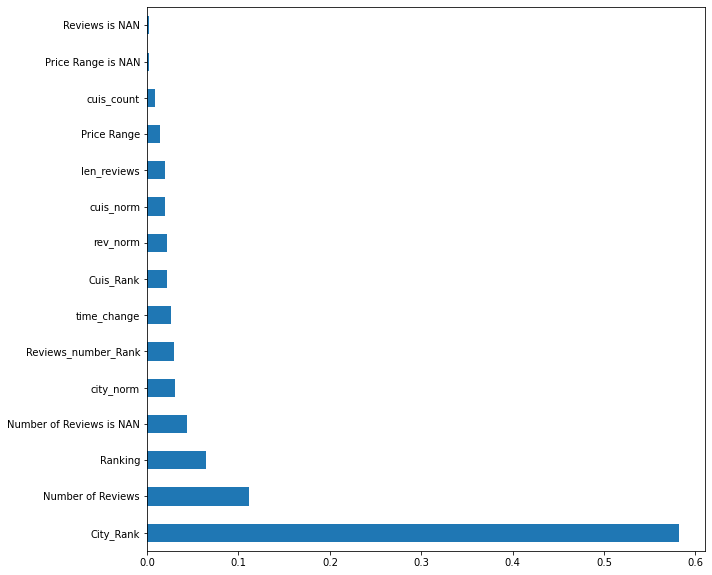

In [29]:
# in RandomForestRegressor it is possible to display the most important features for the model
plt.rcParams ['figure.figsize'] = (10,10)
feat_importances = pd.Series (model.feature_importances_, index = X.columns)
feat_importances.nlargest (15) .plot (kind = 'barh')

## Submission

If everything suits, prepare Submission for kaggle

In [30]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,city_norm,City_Rank,cuis_norm,cuis_count,Cuisine Style is NAN,Cuis_Rank,Price Range is NAN,Number of Reviews is NAN,Reviews_number_Rank,time_change,len_reviews,Reviews is NAN,rev_norm
7022,651.0,2.000000,56.000000,0.0,0.005189,0.778708,-0.002318,2.000000,0,325.500000,0,0,11.625000,10.000000,38.000000,0,-0.011672
5332,2493.0,2.000000,416.000000,0.0,-0.004700,0.346587,0.036958,6.000000,0,415.500000,0,0,5.992788,1.000000,89.000000,0,-0.000486
4763,2659.0,1.832700,6.000000,0.0,0.001837,1.938047,-0.003114,1.000000,0,2659.000000,1,0,443.166667,848.000000,56.000000,0,0.003281
1089,1914.0,1.942238,7.000000,0.0,0.003653,1.852856,0.001047,3.159059,1,605.876532,1,0,273.428571,53.000000,46.000000,0,-0.009676
5751,456.0,2.000000,53.000000,0.0,0.008693,0.823105,-0.002926,3.000000,0,152.000000,0,0,8.603774,85.000000,72.000000,0,-0.008894
5385,1592.0,2.000000,19.000000,0.0,0.004433,1.721081,-0.003716,1.000000,0,1592.000000,0,0,83.789474,71.000000,62.000000,0,0.003419
7225,7093.0,1.891774,11.000000,0.0,-0.004292,1.161264,-0.001370,2.453125,1,2891.414013,1,0,644.818182,193.000000,65.000000,0,0.009807
7735,1263.0,1.813167,13.000000,0.0,0.004433,1.365405,0.000750,3.159463,1,399.751415,1,0,97.153846,314.000000,59.000000,0,-0.007890
3290,6682.0,1.891774,3.000000,0.0,-0.004292,1.093975,0.004966,2.000000,0,3341.000000,1,0,2227.333333,172.991084,48.000000,0,-0.007125
6167,1106.0,1.813167,67.112183,0.0,0.004433,1.195676,0.000750,3.159463,1,350.059434,1,1,16.479869,155.167763,63.842667,1,-0.000758


In [31]:
test_data = test_data.drop(['Rating'], axis=1)

sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [32]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.3s finished


In [33]:
predict_submission

array([3.05 , 4.215, 4.1  , ..., 3.025, 4.5  , 4.255])

In [34]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.050
1,id_1,4.215
2,id_2,4.100
3,id_3,4.245
4,id_4,4.440
5,id_5,4.390
6,id_6,3.270
7,id_7,2.720
8,id_8,4.320
9,id_9,4.575
